# IMDB Comments Classifer with FastAI NLP

In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd

from fastai.text import TextList, URLs, language_model_learner, text_classifier_learner
from fastai.text import load_data, untar_data
from fastai.text import AWD_LSTM

# https://github.com/jupyter/notebook/issues/4369
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

### Unloading sample data to OS default path

In [2]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/imdb_sample/texts.csv')]

In [3]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code

In [4]:
df.loc[3, 'text']

'Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man\'s life - interestingly enough the man\'s entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie "Duty, Honor, Country" are not just mere words blathered from the lips of a high-brassed officer - it is the deep declaration of one man\'s total devotion to his country.<br /><br />Ironically Peck being the liberal that he was garnered a better understanding of the man. He does a great job showing the fearless general tempered with the humane side of the man.'

### Unloading full data to OS default path

In [5]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/imdb/test'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/README'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/unsup'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/imdb.vocab')]

## Language Modelling

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

### Creating Dataset (With the data block API)

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

In [6]:
bs = 8
dataset = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [8]:
dataset.save('dataset.pkl')

In [9]:
dataset = load_data(path, 'dataset.pkl', bs=bs)

In [22]:
type(dataset)

fastai.text.data.TextLMDataBunch

### Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [10]:
dataset.show_batch()

idx,text
0,"original script that xxmaj david xxmaj dhawan has worked on . xxmaj this one was a complete bit y bit rip off xxmaj hitch . i have nothing against remakes as such , but this one is just so lousy that it makes you even hate the original one ( which was pretty decent ) . i fail to understand what actors like xxmaj salman and xxmaj govinda saw in"
1,"was present before the kid was raised by xxmaj lion 's , crazy fight scenes , torture scenes where the posts people are supposed to be tied to wobble , ancient castle interiors that randomly contain zip wires & gymnastic rings , idiotic bad guys who all seem to have extensive facial hair & a central character who has a jaw line resembling a house - brick , can be"
2,"the original book and the xxmaj broadway musical of xxmaj secret xxmaj garden and now i love this enchanting film even more ! xxmaj the seventy minutes went without feeling any of them , i even forgot to check on my sleeping baby as i usually would ! xxmaj the beauty of it is breathtaking , the plot and pace is gripping and the whole film is quite beyond expectation"
3,"her husband run xxmaj xxunk xxmaj school xxmaj boarding school for children . xxmaj george xxmaj bancroft plays a former shyster , xxmaj major xxmaj hurdle , who is "" bequeathed "" a baby boy , xxmaj dan , from a former hoodlum who was murdered . xxmaj he grows fond of the boy and tries to live straight . xxmaj when he is finally made to enroll xxmaj dan"
4,", but her face has narrowed significantly and she has gotten actual definition back in her features . xxbos xxmaj as a cop this actor is pathetic but fascinating . a serial killer is at work in xxmaj new xxmaj york , using poetic ads in the xxmaj village xxmaj voice to attract his preys . xxmaj but in fact he is not the killer really but the real prey"


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [13]:
print(dataset.vocab.itos[:20])

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', 'the', '.', ',', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i']


And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

See tokenization rules to understand xxobs, xxmaj etc.  https://docs.fast.ai/text.transform.html#Tokenizer

In [18]:
dataset.train_ds.x[0]

Text xxbos i did n't know what to expect when i started watching this movie , by the end of it i was pulling my hairs out . xxmaj this was one of the most pathetic movies of this year ... in fact , in the last ten years . xxmaj david xxmaj dhawan should just give up his career as a director . i am yet to come across one original script that xxmaj david xxmaj dhawan has worked on . xxmaj this one was a complete bit y bit rip off xxmaj hitch . i have nothing against remakes as such , but this one is just so lousy that it makes you even hate the original one ( which was pretty decent ) . i fail to understand what actors like xxmaj salman and xxmaj govinda saw in this script . i read somewhere , that this was supposed to be xxmaj govinda 's comeback vehicle . xxmaj if that s true , then only xxmaj god can save his career . xxmaj salman just overacted to the hilt . xxmaj govinda who i think is an actor of very high caliber was completely wasted . xxmaj katrina xxmaj kaif and lara xxmaj dutt

In [23]:
# https://docs.fast.ai/text.learner.html#language_model_learner

learn = language_model_learner(dataset, arch=AWD_LSTM, drop_mult=0.3)

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-06
Min loss divided by 10: 3.31E-07


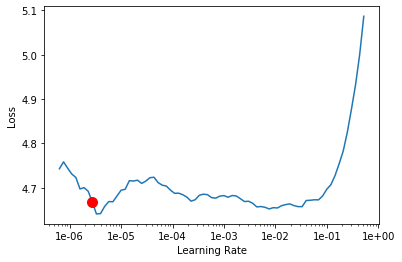

In [29]:
# Skipped last 15 datapoints for clean visualization purpose
learn.recorder.plot(skip_end=15, suggestion=True)

# Scheduled to take about 2 hours 45 minutes on 1xK80 GPU for each cyc_len hence not executed...

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8, 0.7))

In [ ]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned');

In [ ]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('fine_tuned_enc')

## Classifier Modelling

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [31]:
path = untar_data(URLs.IMDB)

In [33]:
dataset_cls = (TextList.from_folder(path, vocab=dataset.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

dataset_cls.save('dataset_cls.pkl')

In [34]:
dataset_cls = load_data(path, 'dataset_cls.pkl', bs=bs)

In [35]:
dataset_cls.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj the freedom of having your own xxmaj sea xxmaj going xxmaj power xxmaj boat , the excitement of going on underwater adventures a rugged , an 's man of an adventurer and xxunk so well endowed ! ) assistants in fine xxmaj bikinis were all definite selling points for "" xxup sea xxup xxunk - 61 ) . \n \n xxmaj just what was the reason for",pos
"xxbos * xxmaj some spoilers * \n \n xxmaj this movie is sometimes subtitled "" xxmaj life xxmaj everlasting . "" xxmaj that 's often taken as reference to the final scene , but more accurately describes how dead and buried this once - estimable series is after this sloppy and illogical send - off . \n \n xxmaj there 's a "" hey kids , let 's",neg
"xxbos xxmaj hear are some of the interesting things our combat hero faith healer xxmaj pat , his son xxmaj gordon ( xxup t.v. ministry seems like a family business . ) and xxmaj terry xxmaj xxunk ( xxmaj won xxmaj miss xxmaj america in 1973 by wearing a swimsuit and showing her legs . xxmaj oh my goodness gracious ! ) say when our poor viewers are sick and",neg
"xxbos xxmaj when i began watching xxmaj the xxmaj muppets xxmaj take xxmaj manhattan , the choppy presentation and dialogue had me convinced i was watching something recent , so you can imagine my surprise when i came to the imdb and read that it was made in 1984 . xxmaj jim xxmaj henson may have ended xxmaj the xxmaj muppet xxmaj show when it was at its peak ,",neg


In [ ]:
# https://docs.fast.ai/text.learner.html#text_classifier_learner

learn = text_classifier_learner(dataset_cls, arch=AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))

In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2), moms=(0.8, 0.7))

In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn.predict("I really loved that movie, it was awesome!")